## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)



---



## 1. Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.2 MB/s eta 0:00:00


In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
from datasets import load_dataset
dataset = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
# Check the data types of 'text' and 'label' columns
print(type(dataset['train']['text']))
print(type(dataset['train']['label']))

# Alternatively, you can check the feature types directly
print(dataset['train'].features)


<class 'list'>
<class 'list'>
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
train= dataset['train']
test = dataset['test']
val = dataset['validation']

In [8]:
def get_tweet(data):
  tweets= [x['text'] for x in data]
  labels= [x['label'] for x in data]
  return tweets, labels

In [9]:
tweets, labels = get_tweet(train)

In [10]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## 3: Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer= Tokenizer(num_words=10000, oov_token='<UNk>')
tokenizer.fit_on_texts(tweets)

In [13]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [14]:
tweets[0]

'i didnt feel humiliated'

## 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [15]:
lengths= [len(t.split(' ')) for t in tweets]

<function matplotlib.pyplot.show(close=None, block=None)>

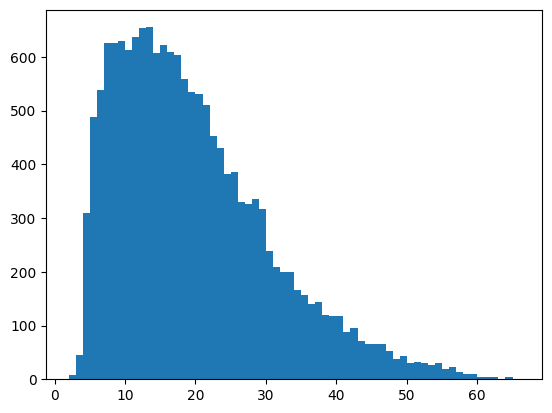

In [16]:
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [17]:
maxlen= 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
def get_sequences(tokenizer, tweets):
  sequences= tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, maxlen=maxlen,padding='post',truncating='post')
  return padded



In [19]:
padded_train_seq= get_sequences(tokenizer, tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## 5: Preparing the Labels

 Since the labels are already numeric (e.g., 0, 1, 2, etc.), we don't need to do anything extra with the labels. We can directly use them for training your model.

<function matplotlib.pyplot.show(close=None, block=None)>

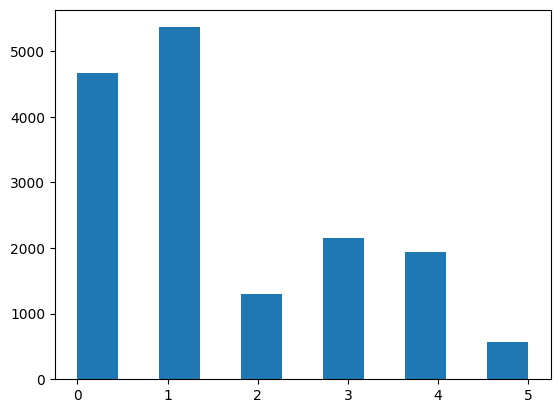

In [ ]:
plt.hist(labels, bins =11)
plt.show

## 6: Creating the Model

1. Creating the model
2. Compiling the model

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss= 'sparse_categorical_crossentropy',
    optimizer= 'adam',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## 7: Training the Model

1. Preparing a validation set
2. Training the model

In [23]:
val_tweets, val_labels= get_tweet(val)
val_sequences= get_sequences(tokenizer, val_tweets)
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [26]:
# Convert labels to NumPy arrays
labels = np.array(labels)
val_labels = np.array(val_labels)

# Check the shapes
print(padded_train_seq.shape)
print(labels.shape)
print(val_sequences.shape)
print(val_labels.shape)

(16000, 50)
(16000,)
(2000, 50)
(2000,)


In [28]:

history = model.fit(
    padded_train_seq, labels,
    validation_data= (val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9685 - loss: 0.1026 - val_accuracy: 0.8885 - val_loss: 0.4045
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9729 - loss: 0.0856 - val_accuracy: 0.8760 - val_loss: 0.4249
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9700 - loss: 0.0901 - val_accuracy: 0.8850 - val_loss: 0.4270
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9827 - loss: 0.0625 - val_accuracy: 0.8940 - val_loss: 0.4029
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9832 - loss: 0.0585 - val_accuracy: 0.8935 - val_loss: 0.4108
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9849 - loss: 0.0480 - val_accuracy: 0.8985 - val_loss: 0.4351
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9840 - loss: 0.0495 - val_accuracy: 0.8980 - val_loss: 0.4262
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9853 - loss: 0.0476 - val_ac

## 8: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

In [31]:
# Evaluating the model on the test set
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels= np.array(test_labels)

test_loss, test_accuracy = model.evaluate(test_sequences, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8772 - loss: 0.5103
Test Loss: 0.47169238328933716
Test Accuracy: 0.8824999928474426


**Visulaizing Training History**

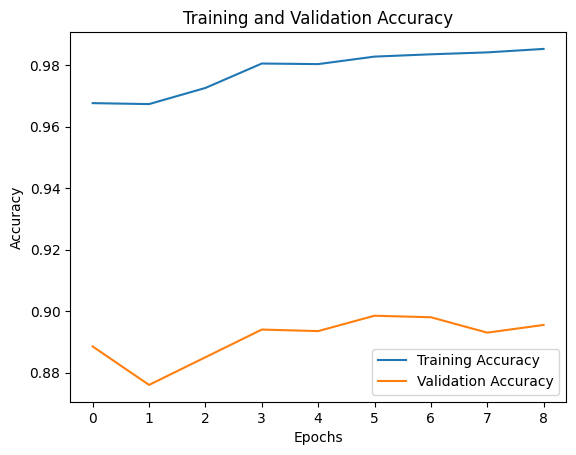

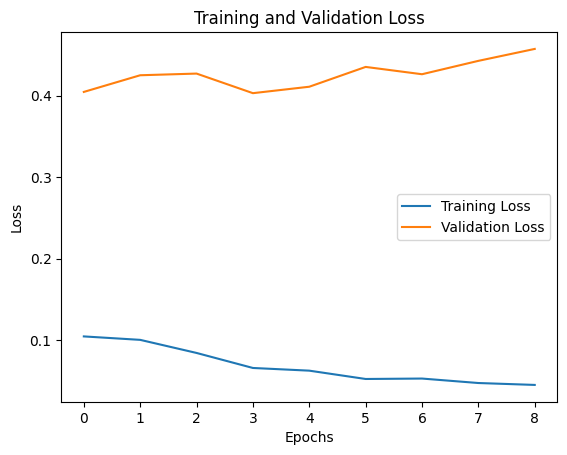

In [32]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


**A Look at Individual Predictions on the Test Set:**

In [33]:
# Get model predictions
predictions = model.predict(test_sequences)

# Convert probabilities to predicted class indices
predicted_classes = predictions.argmax(axis=-1)

# Print out some individual predictions
for i in range(5):  # Print the first 5 predictions
    print(f"Tweet: {test_tweets[i]}")
    print(f"True Label: {test_labels[i]}")
    print(f"Predicted Label: {predicted_classes[i]}")
    print(f"Predicted Emotion: {['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'][predicted_classes[i]]}")
    print("-" * 50)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Tweet: im feeling rather rotten so im not very ambitious right now
True Label: 0
Predicted Label: 0
Predicted Emotion: sadness
--------------------------------------------------
Tweet: im updating my blog because i feel shitty
True Label: 0
Predicted Label: 0
Predicted Emotion: sadness
--------------------------------------------------
Tweet: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Label: 0
Predicted Label: 0
Predicted Emotion: sadness
--------------------------------------------------
Tweet: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
True Label: 1
Predicted Label: 1
Predicted Emotion: joy
--------------------------------------------------
Tweet: i was feeling a little vain when i did this one
True Label: 0
Predicted Label: 0
Predicted Emotion: sadness
--------------------------------------------------


**A Look at All Predictions on the Test Set:**

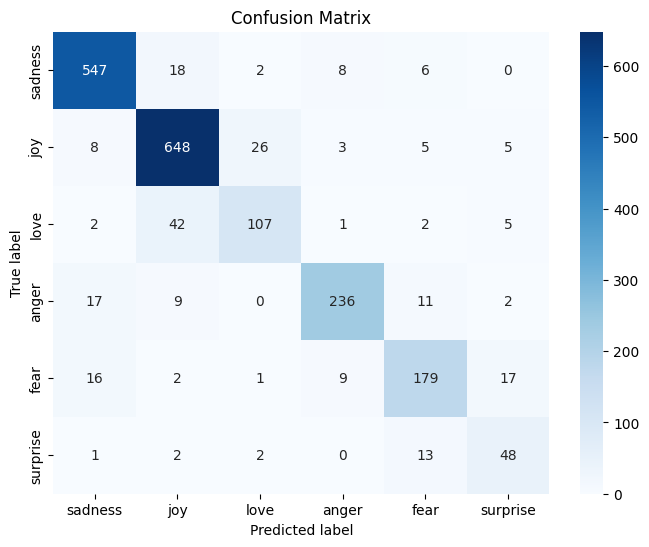

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [35]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(test_labels, predicted_classes, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))


              precision    recall  f1-score   support

     sadness       0.93      0.94      0.93       581
         joy       0.90      0.93      0.92       695
        love       0.78      0.67      0.72       159
       anger       0.92      0.86      0.89       275
        fear       0.83      0.80      0.81       224
    surprise       0.62      0.73      0.67        66

    accuracy                           0.88      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.88      0.88      0.88      2000

